<a href="https://colab.research.google.com/github/ParuN04/DDoS-detection-SDN/blob/main/cyber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# Upload and Extract Dataset
from google.colab import files
uploaded = files.upload()
import zipfile
import os
zip_filename = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('InSDN_dataset')
os.listdir('InSDN_dataset')

Saving archive (1).zip to archive (1).zip


['InSDN_DatasetCSV']

In [ ]:
#Load Datasets

import pandas as pd
ovs_file = 'InSDN_dataset/InSDN_DatasetCSV/OVS.csv'
normal_file = 'InSDN_dataset/InSDN_DatasetCSV/Normal_data.csv'
ovs_df = pd.read_csv(ovs_file)
normal_df = pd.read_csv(normal_file)

print("OVS dataset shape:", ovs_df.shape)
print("Normal dataset shape:", normal_df.shape)

# Ensure label column exists
if 'Label' not in normal_df.columns:
    normal_df['Label'] = 0  # Normal = 0
if 'Label' not in ovs_df.columns:
    ovs_df['Label'] = ovs_df['Label']

# Combine datasets
combined_df = pd.concat([normal_df, ovs_df], axis=0).reset_index(drop=True)
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Combined dataset shape:", combined_df.shape)
print("Class distribution:\n", combined_df['Label'].value_counts())



OVS dataset shape: (138722, 84)
Normal dataset shape: (68424, 84)
Combined dataset shape: (207146, 84)
Class distribution:
 Label
Normal        68424
DoS           52471
DDoS          48413
Probe         36372
BFA            1110
Web-Attack      192
BOTNET          164
Name: count, dtype: int64


In [ ]:

# Keep only Normal + DDoS

ovs_df['Label'] = ovs_df['Label'].replace('DoS', 'DDoS')

ovs_ddos_df = ovs_df[ovs_df['Label'].isin(['Normal', 'DDoS'])]
normal_ddos_df = normal_df.copy()
normal_ddos_df['Label'] = 'Normal'

print("Filtered OVS shape:", ovs_ddos_df.shape)
print("Filtered Normal shape:", normal_ddos_df.shape)



Filtered OVS shape: (52471, 84)
Filtered Normal shape: (68424, 84)


In [ ]:

# Combine datasets

combined_df = pd.concat([ovs_ddos_df, normal_ddos_df], axis=0).reset_index(drop=True)
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Combined shape:", combined_df.shape)
print("Class distribution:\n", combined_df['Label'].value_counts())



Combined shape: (120895, 84)
Class distribution:
 Label
Normal    68424
DDoS      52471
Name: count, dtype: int64


In [ ]:

# Preprocess

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


numeric_cols = combined_df.select_dtypes(include=[np.number]).columns.tolist()
df_numeric = combined_df[numeric_cols + ['Label']]


X = df_numeric.drop(columns=['Label']).values
y = (df_numeric['Label'] == 'DDoS').astype(int).values  # DDoS=1, Normal=0


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, shuffle=True
)



In [ ]:

# Build Binary DNN model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import time

model = Sequential([
    Dense(32, input_dim=X_train.shape[1], activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # sigmoid → binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,105 (12.13 KB)

 Trainable params: 3,105 (12.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Train the model

start_time = time.time()
history = model.fit(X_train, y_train, batch_size=32, epochs=12, validation_split=0.2)
end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds")


Epoch 1/12
2267/2267 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9589 - loss: 0.1182 - val_accuracy: 0.9928 - val_loss: 0.0187
Epoch 2/12
2267/2267 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9945 - loss: 0.0164 - val_accuracy: 0.9947 - val_loss: 0.0139
Epoch 3/12
2267/2267 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9952 - loss: 0.0135 - val_accuracy: 0.9973 - val_loss: 0.0098
Epoch 4/12
2267/2267 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9967 - loss: 0.0093 - val_accuracy: 0.9980 - val_loss: 0.0061
Epoch 5/12
2267/2267 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9985 - loss: 0.0065 - val_accuracy: 0.9994 - val_loss: 0.0045
Epoch 6/12
2267/2267 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9994 - loss: 0.0033 - val_accuracy: 0.9995 - val_loss: 0.0033
Epoch 7/12
2267/2267 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9995 - loss: 0.0027 - val_accuracy: 0.9998 - val_loss: 0.0017
Epoch 8/12
2267/2267 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9996 - loss: 0.0022 - 

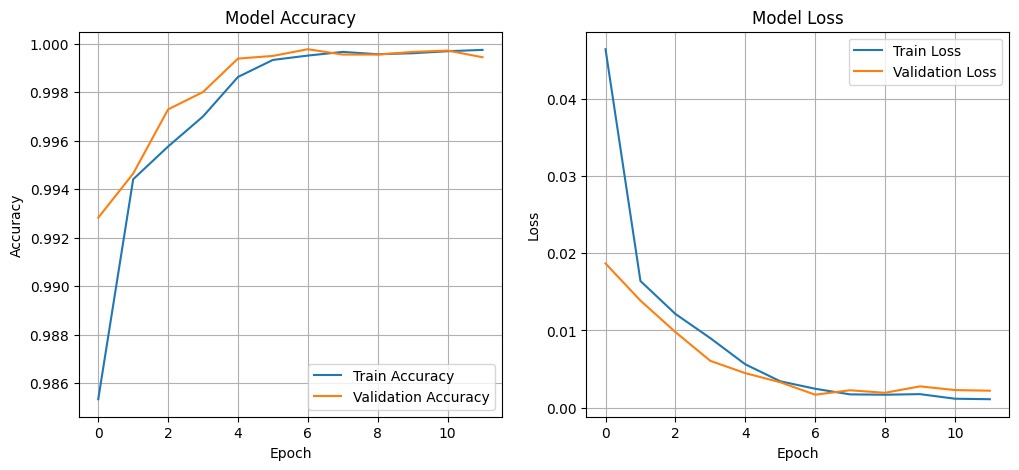

In [ ]:

# Plot Training Metrics

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()



In [ ]:

# Evaluate on Test Set

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print("Confusion Matrix:\n", cm)
print(f"Accuracy: {acc*100:.2f}%\n")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Normal", "DDoS"]))



945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Confusion Matrix:
 [[17176    13]
 [   12 13023]]
Accuracy: 99.92%

Classification Report:
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     17189
        DDoS       1.00      1.00      1.00     13035

    accuracy                           1.00     30224
   macro avg       1.00      1.00      1.00     30224
weighted avg       1.00      1.00      1.00     30224



In [ ]:

# Real-Time SDN Mitigation Simulation
import random, time

def simulate_realtime_ddos(model, X_data, y_data, delay=0.2, n_samples=50, threshold=3):
    print("=== Starting SDN Real-Time DDoS Simulation ===\n")
    attack_streak = 0
    idxs = random.sample(range(len(X_data)), n_samples)

    for i in idxs:
        flow = X_data[i].reshape(1, -1)
        true_label = y_data[i]
        prob = model.predict(flow, verbose=0)[0][0]
        pred_label = int(prob > 0.5)

        status = "DDoS " if pred_label == 1 else "Normal "
        gt = "DDoS" if true_label == 1 else "Normal"

        print(f"Flow #{i}: Prediction={status} | Ground Truth={gt} | Confidence={prob:.2f}")

        if pred_label == 1:
            attack_streak += 1
            if attack_streak >= threshold:
                print(f"⚡ Mitigation triggered at flow #{i}! Blocking suspected attacker 🚫\n")
                attack_streak = 0
        else:
            attack_streak = 0

        time.sleep(delay)

    print("\n=== Simulation Finished ===")

simulate_realtime_ddos(model, X_test, y_test, delay=0.15, n_samples=40, threshold=4)



=== Starting SDN Real-Time DDoS Simulation ===

Flow #747: Prediction=Normal  | Ground Truth=Normal | Confidence=0.00
Flow #26007: Prediction=DDoS  | Ground Truth=DDoS | Confidence=1.00
Flow #26204: Prediction=DDoS  | Ground Truth=DDoS | Confidence=1.00
Flow #3558: Prediction=Normal  | Ground Truth=Normal | Confidence=0.00
Flow #23937: Prediction=DDoS  | Ground Truth=DDoS | Confidence=1.00
Flow #12276: Prediction=Normal  | Ground Truth=Normal | Confidence=0.00
Flow #27408: Prediction=Normal  | Ground Truth=Normal | Confidence=0.00
Flow #11580: Prediction=Normal  | Ground Truth=Normal | Confidence=0.00
Flow #187: Prediction=Normal  | Ground Truth=Normal | Confidence=0.00
Flow #27432: Prediction=Normal  | Ground Truth=Normal | Confidence=0.00
Flow #13678: Prediction=DDoS  | Ground Truth=DDoS | Confidence=0.99
Flow #7673: Prediction=DDoS  | Ground Truth=DDoS | Confidence=1.00
Flow #7627: Prediction=Normal  | Ground Truth=Normal | Confidence=0.00
Flow #17678: Prediction=Normal  | Ground Tr

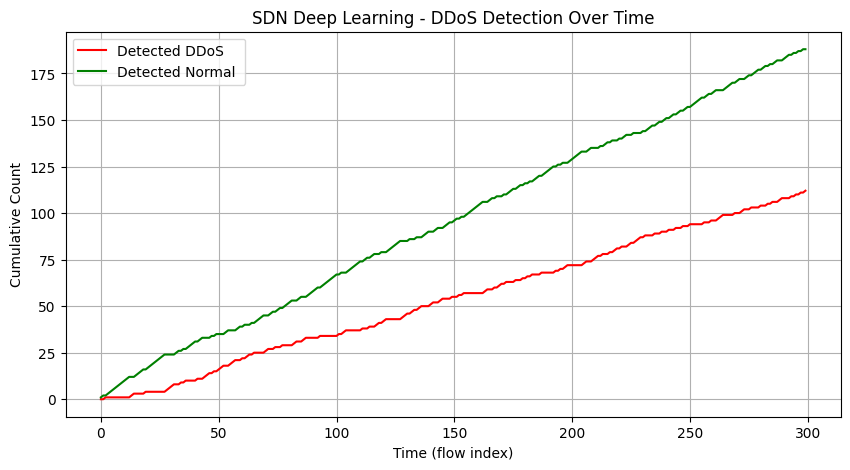

In [ ]:

# Plot DDoS Detection Over Time

def plot_ddos_detection(model, X_data, y_data, n_samples=200):
    idxs = np.random.choice(len(X_data), n_samples, replace=False)
    attacks, normals, timeline = [], [], []

    attack_count, normal_count = 0, 0
    for t, i in enumerate(idxs):
        flow = X_data[i].reshape(1, -1)
        pred_label = int(model.predict(flow, verbose=0)[0][0] > 0.5)

        if pred_label == 1:
            attack_count += 1
        else:
            normal_count += 1

        attacks.append(attack_count)
        normals.append(normal_count)
        timeline.append(t)

    plt.figure(figsize=(10,5))
    plt.plot(timeline, attacks, label="Detected DDoS ", color="red")
    plt.plot(timeline, normals, label="Detected Normal ", color="green")
    plt.xlabel("Time (flow index)")
    plt.ylabel("Cumulative Count")
    plt.title("SDN Deep Learning - DDoS Detection Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_ddos_detection(model, X_test, y_test, n_samples=300)

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


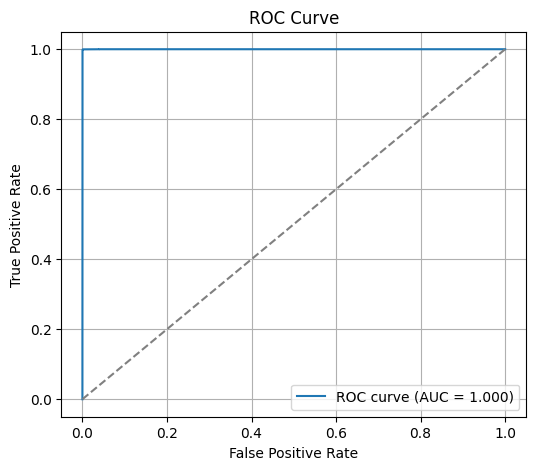

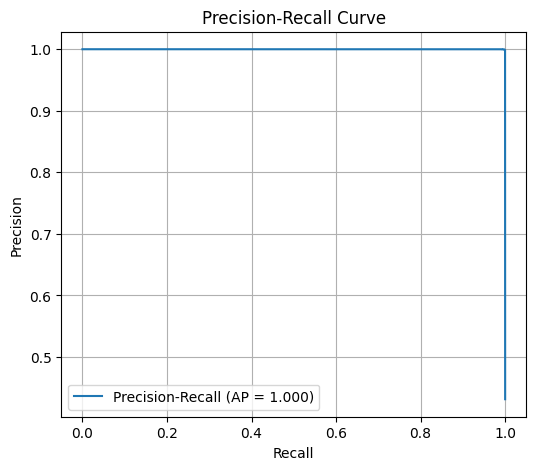

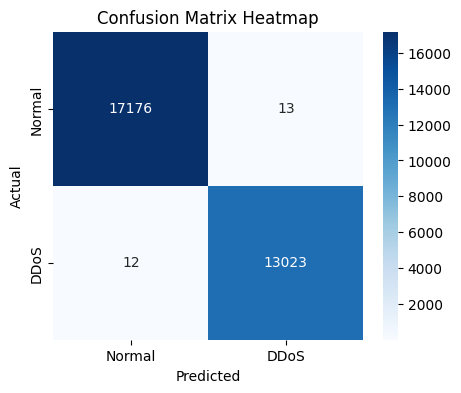

Metrics Table:
       Metric     Score
0   Accuracy  0.999173
1  Precision  0.999003
2     Recall  0.999079
3   F1-Score  0.999041


In [ ]:

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import pandas as pd

# ROC Curve
y_scores = model.predict(X_test).flatten()
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_scores)
avg_prec = average_precision_score(y_test, y_scores)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'Precision-Recall (AP = {avg_prec:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# Confusion Matrix Heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','DDoS'], yticklabels=['Normal','DDoS'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Metrics Table
from sklearn.metrics import precision_score, recall_score, f1_score
metrics_table = pd.DataFrame({
    'Metric':['Accuracy','Precision','Recall','F1-Score'],
    'Score':[acc, precision_score(y_test,y_pred), recall_score(y_test,y_pred), f1_score(y_test,y_pred)]
})
print("Metrics Table:\n", metrics_table)


In [ ]:

import random, time, csv
import datetime

def simulate_realtime_ddos_logging(model, X_data, y_data, delay=0.2, n_samples=50, threshold=3, log_file='sdn_ddos_log.csv'):
    print("=== Starting SDN Real-Time DDoS Simulation with Logging ===\n")
    attack_streak = 0
    idxs = random.sample(range(len(X_data)), n_samples)

    # Open CSV log
    with open(log_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Timestamp', 'Flow_Index', 'Prediction', 'Ground_Truth', 'Confidence', 'Mitigation_Triggered'])

        for i in idxs:
            flow = X_data[i].reshape(1, -1)
            true_label = y_data[i]
            prob = model.predict(flow, verbose=0)[0][0]
            pred_label = int(prob > 0.5)

            status = "DDoS " if pred_label == 1 else "Normal "
            gt = "DDoS" if true_label == 1 else "Normal"
            mitigation = ''

            if pred_label == 1:
                attack_streak += 1
                if attack_streak >= threshold:
                    mitigation = 'Yes'
                    print(f"⚡ Mitigation triggered at flow #{i}! Blocking suspected attacker \n")
                    attack_streak = 0
            else:
                attack_streak = 0

            writer.writerow([datetime.datetime.now(), i, status, gt, f"{prob:.2f}", mitigation])
            print(f"Flow #{i}: Prediction={status} | Ground Truth={gt} | Confidence={prob:.2f}")
            time.sleep(delay)
    print("\n=== Simulation Finished ===")
    print(f"Log saved to {log_file}")

simulate_realtime_ddos_logging(model, X_test, y_test, delay=0.15, n_samples=40, threshold=4)

=== Starting SDN Real-Time DDoS Simulation with Logging ===

Flow #11765: Prediction=DDoS  | Ground Truth=DDoS | Confidence=1.00
Flow #23986: Prediction=Normal  | Ground Truth=Normal | Confidence=0.00
Flow #19919: Prediction=DDoS  | Ground Truth=DDoS | Confidence=1.00
Flow #23886: Prediction=Normal  | Ground Truth=Normal | Confidence=0.00
Flow #2392: Prediction=Normal  | Ground Truth=Normal | Confidence=0.00
Flow #13564: Prediction=Normal  | Ground Truth=Normal | Confidence=0.00
Flow #24539: Prediction=Normal  | Ground Truth=Normal | Confidence=0.00
Flow #23592: Prediction=Normal  | Ground Truth=Normal | Confidence=0.00
Flow #5358: Prediction=DDoS  | Ground Truth=DDoS | Confidence=1.00
Flow #3410: Prediction=DDoS  | Ground Truth=DDoS | Confidence=1.00
Flow #25674: Prediction=Normal  | Ground Truth=Normal | Confidence=0.00
Flow #12936: Prediction=DDoS  | Ground Truth=DDoS | Confidence=1.00
Flow #18840: Prediction=DDoS  | Ground Truth=DDoS | Confidence=1.00
Flow #22960: Prediction=Normal